# Evaluate Classifier Performance

## Introduction


The current Jupyter notebook illustrates the implementation of 2 classification models:
- Naive Bayes
- Support Vector Machines

Those models are then evaluated based on their performance while executing the same goal: *classification of IT Support Ticktets* on a given dataset. 

Each ticket is comprised of a short description of an issue being faced by an end-user while utilising a particular IT service. Those issues varies in root causes and can only be handled by specific teams.

Hence, in a large corporation, with domain-specific teams, the automatic classification of the IT Support Tickets represents a real business advantage by reducing user waiting times.

In [25]:
# importing required libraries

import matplotlib.pyplot as plt
import numpy as np
import sys
import pandas as pd

from yellowbrick.model_selection import CVScores
from yellowbrick.text import FreqDistVisualizer
from yellowbrick.classifier import ClassificationReport

import scikitplot as skplt

import nltk
nltk.download('punkt', download_dir='.')
from nltk.stem import PorterStemmer

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, plot_roc_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve

[nltk_data] Downloading package punkt to ....
[nltk_data]   Package punkt is already up-to-date!


## Dataset Overview

Using pandas to load the dataset from a csv file (*raw.csv*) containing:
- Column 1: Description of the issue faced by the user
- Column 2: Category of the issue (Application, Network, Database, etc...)

In [3]:
# Loading Data
df = pd.read_csv("datasets/tickets.csv")

In [4]:
# Displaying the 10 first and last rows of the raw dataset from the dataframe

In [5]:
df.head(10) # displays 10 first rows

,description,category
0,hi since recruiter lead permission approve req...,Application
1,re expire days hi ask help update passwords co...,Application
2,verification warning hi has got attached pleas...,Application
3,please dear looks blacklisted receiving mails ...,Application
4,dear modules report report cost thank much reg...,Application
5,please action reports dear way help close thes...,Application
6,hello please fill date,Application
7,secondary hi please provide secondary ledger u...,Application
8,copy hi receive copy behavior expect receive m...,Application
9,invitation strategy workshop february manchest...,Application


In [6]:
df.tail(10) # displays 10 last rows

,description,category
2990,sent monday printer issues hi xerox printer ac...,Database
2991,sent tuesday re notification upgrade la thanks...,Database
2992,sent monday re sporadically send certain invit...,Database
2993,one plastic pieces covering hinge keeps screen...,Database
2994,sent friday problem data aud si ca sa sa data ...,Database
2995,sent tuesday feedback follow up conf call hell...,Database
2996,sent monday issues hi keep getting errors whil...,Database
2997,sent monday en working properly hi guys we hav...,Database
2998,sent wednesday july hi please log incident for...,Database
2999,sent tuesday july connection issues hello have...,Database


Text(0, 0.5, 'Number of rows')

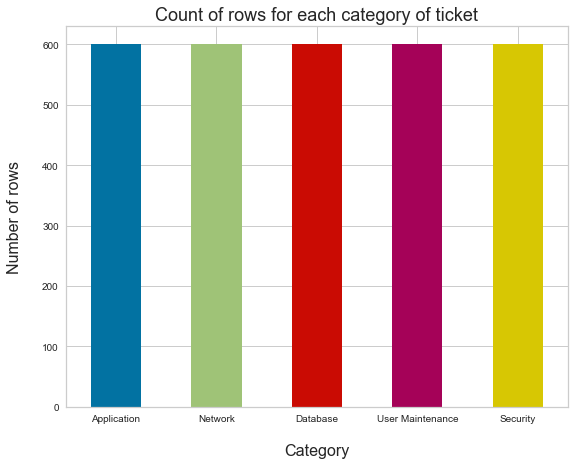

In [7]:
# Visualizing the number of rows for each category
df["category"].value_counts().plot(kind = "bar", figsize=(9, 7), rot=0)

plt.title("Count of rows for each category of ticket", fontsize=18)
plt.xlabel("Category", labelpad=20, fontsize=16)
plt.ylabel("Number of rows", labelpad=20, fontsize=16)

### Tokenization
In this process, each sentence for each description are broken down into individual words.
This will facilitate the manipulation of the dataset during feature extraction.

In [8]:
df["description"] = df["description"].apply(nltk.word_tokenize)

In [9]:
df.head(5)

,description,category
0,"[hi, since, recruiter, lead, permission, appro...",Application
1,"[re, expire, days, hi, ask, help, update, pass...",Application
2,"[verification, warning, hi, has, got, attached...",Application
3,"[please, dear, looks, blacklisted, receiving, ...",Application
4,"[dear, modules, report, report, cost, thank, m...",Application


## Word Stemming

Using word stemming to reduce each word to its word stem

In [10]:
stemmer = PorterStemmer()
df["description"] = df["description"].apply(lambda sentences: [stemmer.stem(word) for word in sentences])
df.head()

,description,category
0,"[hi, sinc, recruit, lead, permiss, approv, req...",Application
1,"[re, expir, day, hi, ask, help, updat, passwor...",Application
2,"[verif, warn, hi, ha, got, attach, pleas, addr...",Application
3,"[pleas, dear, look, blacklist, receiv, mail, a...",Application
4,"[dear, modul, report, report, cost, thank, muc...",Application


Concatenating words back together, separated by a single whitespace

In [11]:
df["description"] = df["description"].apply(lambda sentences: " ".join(sentences))

In [12]:
df.head()

,description,category
0,hi sinc recruit lead permiss approv requisit m...,Application
1,re expir day hi ask help updat password collea...,Application
2,verif warn hi ha got attach pleas address best...,Application
3,pleas dear look blacklist receiv mail anymor s...,Application
4,dear modul report report cost thank much regard,Application


# Feature Selection

Using a Count Vectorizer to obtain the frequency of each word in the overall dataset

In [13]:
token_count_vect = CountVectorizer()
token_counts = token_count_vect.fit_transform(df["description"])

### Visualizing the most frequently-occurring words 

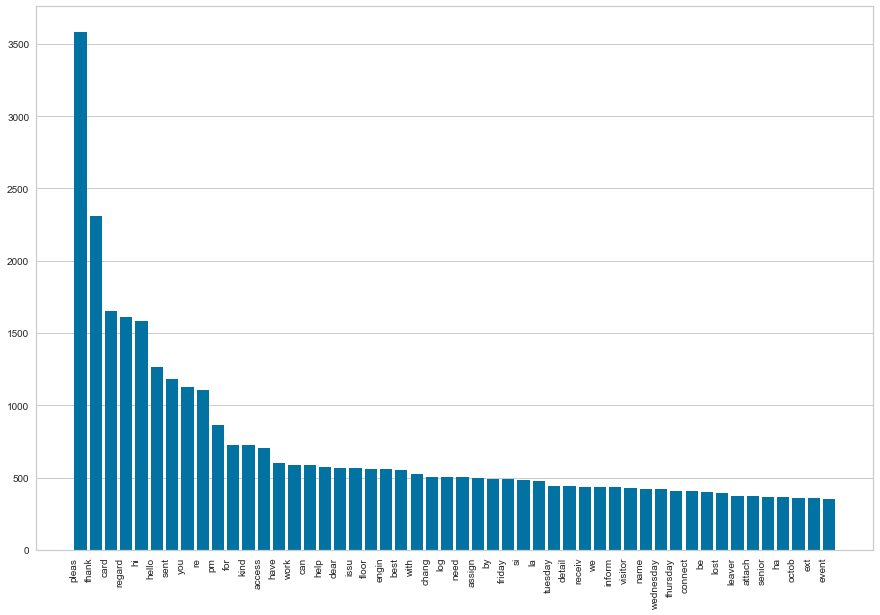

In [14]:
features   = token_count_vect.get_feature_names()
visualizer = FreqDistVisualizer(features=features, orient='v', size=(1080, 720))
visualizer.fit(token_counts);

 ### Using Term Frequency Inverse Document Frequency
TFIDF is a statistical measure that will help us determine the relevancy of each word throughout the dataset

In [15]:
token_count_transformer = TfidfTransformer().fit(token_counts)
token_counts = token_count_transformer.transform(token_counts)

In [16]:
df_idf = pd.DataFrame(token_count_transformer.idf_, index = token_count_vect.get_feature_names(), columns=["idf_weights"])
df_idf.sort_values(by=["idf_weights"])
df_idf.head(5)

,idf_weights
ab,7.908089
abandon,7.908089
abil,6.927259
abl,5.074875
abnorm,8.313554


# Dataset Splitting

The dataset is split into training batch (80%) and testing batch (20%). This will help gauge better the accuracy after training and detect whether the model if overfitting or not.

In [17]:
description_training, description_testing, category_training, category_testing = train_test_split(token_counts, df["category"], test_size=.2, random_state=69)

## Classifiers

### Classifier #1: Naive Bayes

In [18]:
nb_model = MultinomialNB().fit(description_training, category_training)
nb_predicted = nb_model.predict(description_testing)

print("Accuracy of Naive Bayesian Model: %s" %(np.mean(nb_predicted==category_testing)))

Accuracy of Naive Bayesian Model: 0.7716666666666666


### Classifier #2: Support Vector Machine

In [19]:
lr_model = LogisticRegression(max_iter=1000, penalty='l2')
lr_model.fit(description_training, category_training)
lr_predicted = lr_model.predict(description_testing)

print("Accuracy of L2 Logistic Model: %s" %(np.mean(lr_predicted==category_testing)))

Accuracy of L2 Logistic Model: 0.7833333333333333


## Evaluation Metrics

The following metrics will be used to evaluate the performance of both classifiers on the given dataset and hence help the decision-making when choosing the best classifier for the current problem domain.

### Confusion Matrix

The confusion matrix will be used to identify the performance of the classifiers in terms of how often they correctly or incorrectly classify to a ticket category.

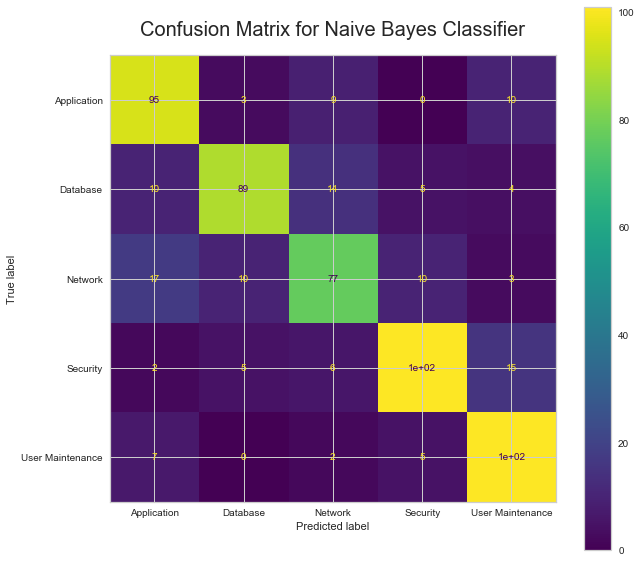

In [20]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.title("Confusion Matrix for Naive Bayes Classifier", fontdict={'fontsize': 20}, pad=20)
plot_confusion_matrix(nb_model, description_testing, category_testing, ax=ax)
plt.show();

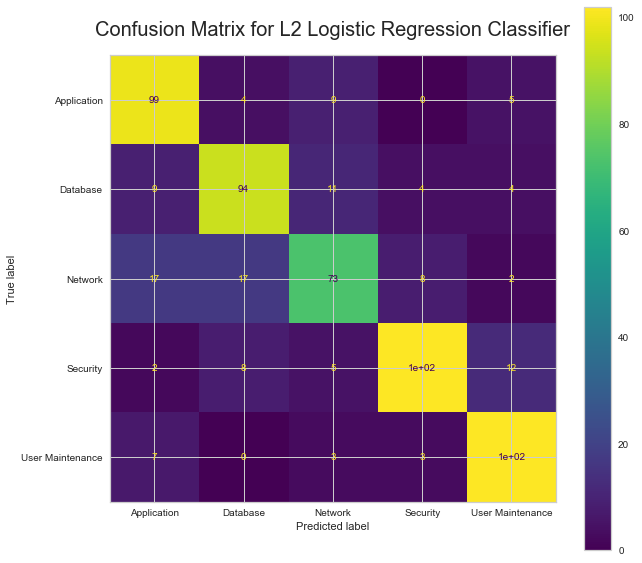

In [21]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.title("Confusion Matrix for L2 Logistic Regression Classifier", fontdict={'fontsize': 20}, pad=20)
plot_confusion_matrix(lr_model, description_testing, category_testing, ax=ax)
plt.show();

### k-fold Cross Validation

The k-fold evaluates the models by splitting the training set into subsets called folds. In the subsequent cells, the training set has been split into 12 folds. Then, each model has been evaluated each time during the 12 cycles and assigned a given score for each cycle. The mean score is displayed in a legen on the plot.

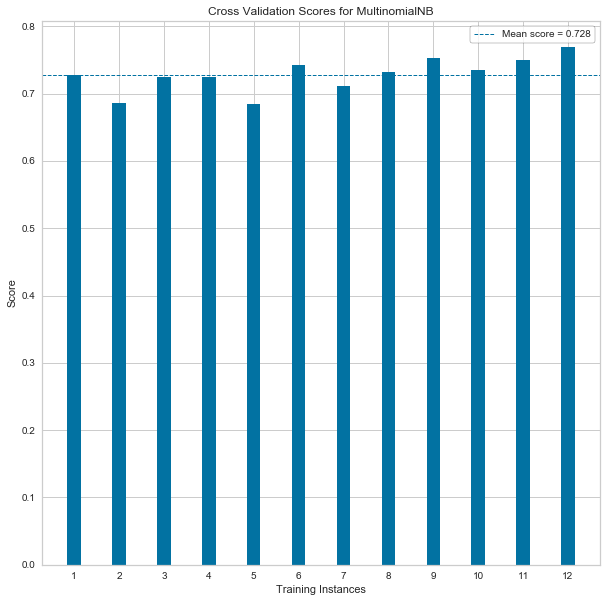

In [35]:
fig, ax = plt.subplots(figsize=(10, 10))

cv = StratifiedKFold(n_splits=12)
visualizer = CVScores(nb_model, cv=cv, scoring='f1_weighted', ax=ax)

visualizer.fit(description_training, category_training)        # Fit the data to the visualizer
visualizer.show();           # Finalize and render the figur

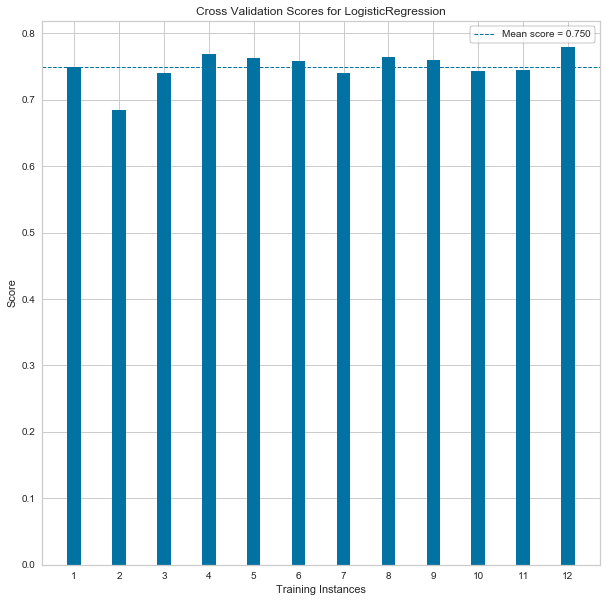

In [36]:
fig, ax = plt.subplots(figsize=(10, 10))
cv = StratifiedKFold(n_splits=12)

visualizer = CVScores(lr_model, cv=cv, scoring='f1_weighted', ax=ax)

visualizer.fit(description_training, category_training)
visualizer.show();

### Precision-Recall Curve

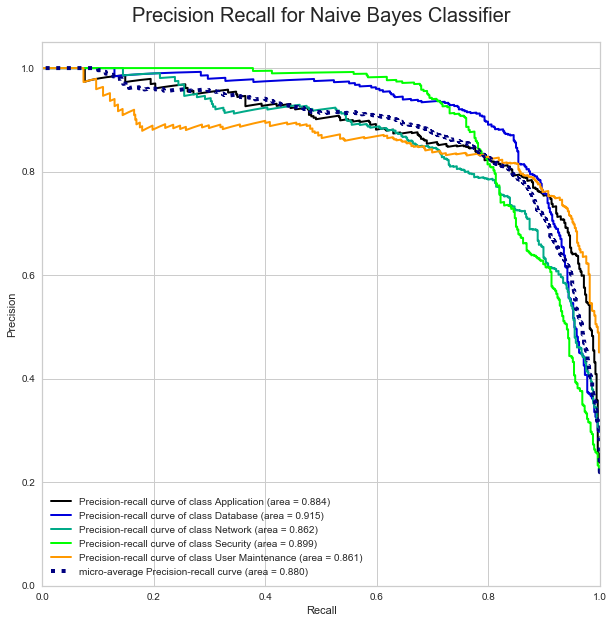

In [22]:
# Get predicted probabilities for Naive Bayes Classifier
category_predicted_probability = nb_model.predict_proba(description_training)

#plotting
fig, ax = plt.subplots(figsize=(10, 10)) 
skplt.metrics.plot_precision_recall(category_training, category_predicted_probability, cmap='nipy_spectral', ax=ax)
plt.title("Precision Recall for Naive Bayes Classifier", fontdict={'fontsize': 20}, pad=20)
plt.show();

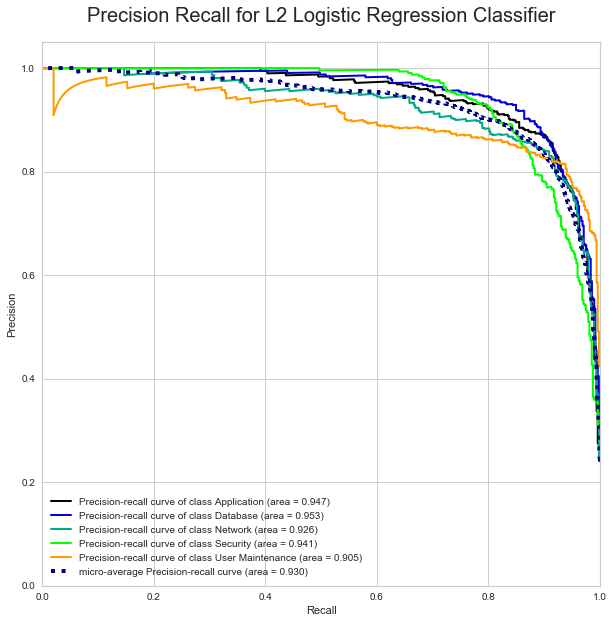

In [23]:
# Get predicted probabilities for L2 Logistic Regression Classifier
category_predicted_probability = lr_model.predict_proba(description_training)

#plotting
fig, ax = plt.subplots(figsize=(10, 10)) 
skplt.metrics.plot_precision_recall(category_training, category_predicted_probability, cmap='nipy_spectral', ax=ax)
plt.title("Precision Recall for L2 Logistic Regression Classifier", fontdict={'fontsize': 20}, pad=20)
plt.show();

## Discussion

### Confusion Matrix

When comparing the metrics gathered from the Confusion Matrix, it has been observed that both models differ on the based on the following characteristics:

- **Accuracy**

The L2 Logistic Regression Model has an average accuracy of 0.7833333333333333 while the Naive Bayes model has an average prediction accuracy of 0.7716666666666666.

- **Positive Predictive Value**

The L2 Logistic Regression Model has a better positive predictive value for the categories/classes (*Application*, *Database*) while the Naive Bayes Model has a slight higher positive predictive value for the category/class *Network*.   


- **Negative Predictive Value** 


The L2 Logistic Regression Model has an overall better negative predictive value over the Naive Bayes Model and has lower probability values on average for negative predictions than the Naive Bayes Model. 


### k-fold Cross Validation

The k-fold validation was performed on both models with the same number of cycles (*12*). It has been observed that the L2 Logistic Regression has on average across all cycles a better mean score for the prediction accuracy (*0.750*) as compared to the Naive Bayes Model (*0.728*) 

### Precision-Recall Curve

It has been observed that the L2 Logistic Regression has a higher precision-recall value for every category/classes than the Naive Bayes. This indicates that the L2 model has a higher precision and higher recall, which further means that the model is returning accurate results as well as returning a majority of all positive results.

## References

- https://thesai.org/Downloads/Volume4No11/Paper_5-Performance_Comparison_between_Na%C3%AFve_Bayes.pdf
- https://stackabuse.com/the-naive-bayes-algorithm-in-python-with-scikit-learn/
- https://www.datacamp.com/community/tutorials/decision-tree-classification-python
- https://stackabuse.com/k-nearest-neighbors-algorithm-in-python-and-scikit-learn/
- https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python
- https://stackabuse.com/implementing-svm-and-kernel-svm-with-pythons-scikit-learn/
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_precision_recall_curve.html
- https://scikit-plot.readthedocs.io/en/stable/metrics.html
- https://notebook.community/reiinakano/scikit-plot/examples/jupyter_notebooks/plot_precision_recall_curve